In [ ]:
# Clone iGPT + install dependencies
!git clone https://github.com/openai/image-gpt
!pip install -r image-gpt/requirements.txt

In [75]:
import matplotlib.pyplot as plt
import PIL 
import numpy as np

In [122]:
# Constants
BATCH = 8 # Batch size
N_PX = 32 # Number of pixels
MODEL_SIZE = 's' # 'm' and 'l' are also available
CKPT = 1_000_000 # " 131_000, 262_000, 524_000 are also available. For generation task we take the last one.
CROP_N_PX = 20 # Number of pixels cropped

In [ ]:
# Downloads
!mkdir -p /image-gpt/models/downloads
!python image-gpt/download.py --model {MODEL_SIZE} --ckpt {CKPT} --clusters --download_dir ./downloads/

In [72]:
CLUSTERS = np.load("downloads/kmeans_centers.npy")

In [124]:
def squared_euclidean_distance(a, b):
    # a -> img shape : [(32*32) -> 1024, 3]
    # b -> clusters shape : [512, 3] 
    b = np.transpose(b)
    a2 = np.sum(np.square(a), axis=1, keepdims=True) # a2 shape : [1024, 1]
    b2 = np.sum(np.square(b), axis=0, keepdims=True) # b2 shape : [512, 1]
    ab = np.matmul(a, b) # ab shape : [1024, 512]
    # (a - b) ** 2 = a**2 - 2ab - b**2
    d = a2 - 2*ab + b2
    # d shape: [1024, 512] -> each pixel in the image has assigned 512 distances to the clusters
    return d

def color_quantize(x, np_clusters):
    x = np.reshape(x, [-1, 3])
    # x -> img shape: [1024, 3]
    d = squared_euclidean_distance(x, CLUSTERS)
    d = np.argmin(d, 1)
    # d shape: [1024,] -> each pixel in the image has assigned index to the cluster with the minimal distance
    return d

def cluster_to_pixel(img):
    # img shape : [H*W, ]
    H, W = len(img) // 32, 32
    pixels = np.rint(127.5 * (CLUSTERS[img] + 1.0)).reshape(H, W, 3)
    return pixels.astype(np.uint8)

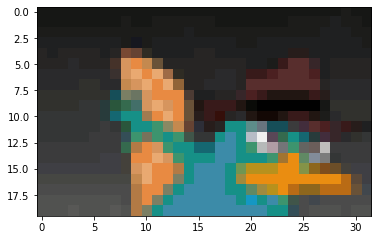

In [123]:
def preprocessing(img, primers=False):
    # Resize
    img = img.resize((N_PX, N_PX))
    img = np.array(img).astype('float32')

    # img shape: [32, 32, 3] with range <0,255>

    # Normalization
    img = img / 127.5 - 1
    # img shape: [32, 32, 3] with range <-1, 1>

    # Convert to 9-bit Colour Palette
    img = color_quantize(img, CLUSTERS)
    # img shape: [32*32 -> (1024),]

    if primers:
        img = img.reshape(N_PX, N_PX)
        img = img[:CROP_N_PX, :].flatten()
        # img shape : [(N_PX - CROP_N_PX) * N_PX,]

    return img

img = PIL.Image.open("pepe.jpg")
pre_img = preprocessing(img, primers=True)
plt.imshow(cluster_to_pixel(pre_img))

In [ ]:
def make_batch(img):
    img_batch = BATCH * [img]
    